In [49]:
# Database and data manipulation
import sqlite3
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualizations
sns.set(style="darkgrid")  # Set a clean style for Seaborn
plt.rcParams["figure.figsize"] = (10, 6)  # Set default figure size

# Suppress warnings (optional)
import warnings
warnings.filterwarnings("ignore")

Total Sales by Category query - to get a baseline of where we are at

  Category  TotalSales
0  Spirits    60430.71
1     Beer    58121.05
2     Wine    34107.46


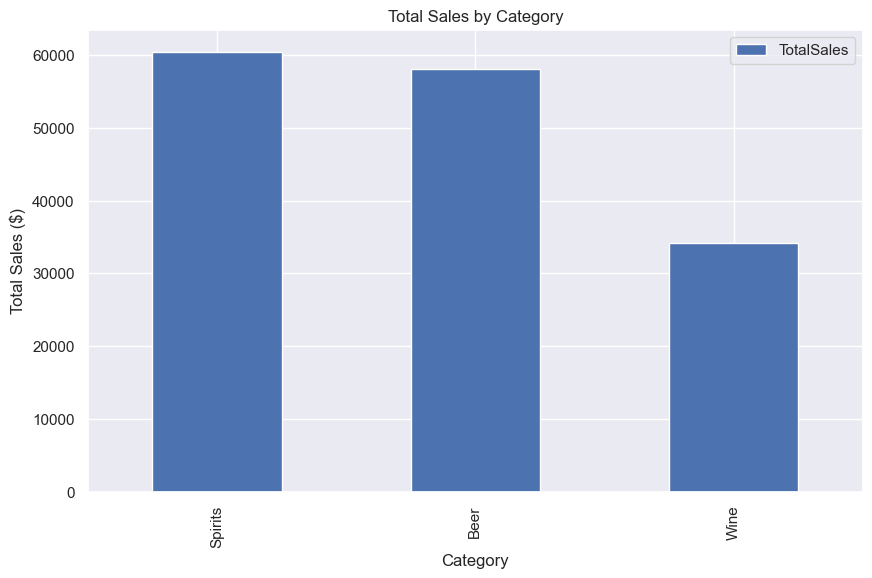

In [50]:
# Query: Total sales by category
query = """
SELECT p.Category, SUM(s.TotalAmount) AS TotalSales
FROM Sales s
JOIN Products p ON s.ProductID = p.ProductID
GROUP BY p.Category
ORDER BY TotalSales DESC
"""

# Use context manager to query the database
with sqlite3.connect("../data/sales_data.db") as conn:
    df = pd.read_sql_query(query, conn)

# Display the results
print(df)

# Visualize the results
df.plot(kind="bar", x="Category", y="TotalSales", title="Total Sales by Category")
plt.ylabel("Total Sales ($)")
plt.show()

Total Sales by Month - I want to see if any particular month is sticking out and what variables surround it.

      Month  TotalSales
0   2024-05     7146.80
1   2024-06    11859.51
2   2024-07    13970.81
3   2024-08    16996.69
4   2024-09    12077.27
5   2024-10     6335.59
6   2024-11    16702.63
7   2024-12    12796.91
8   2025-01    10328.44
9   2025-02    12427.64
10  2025-03    13601.28
11  2025-04    14573.88
12  2025-05     3841.77


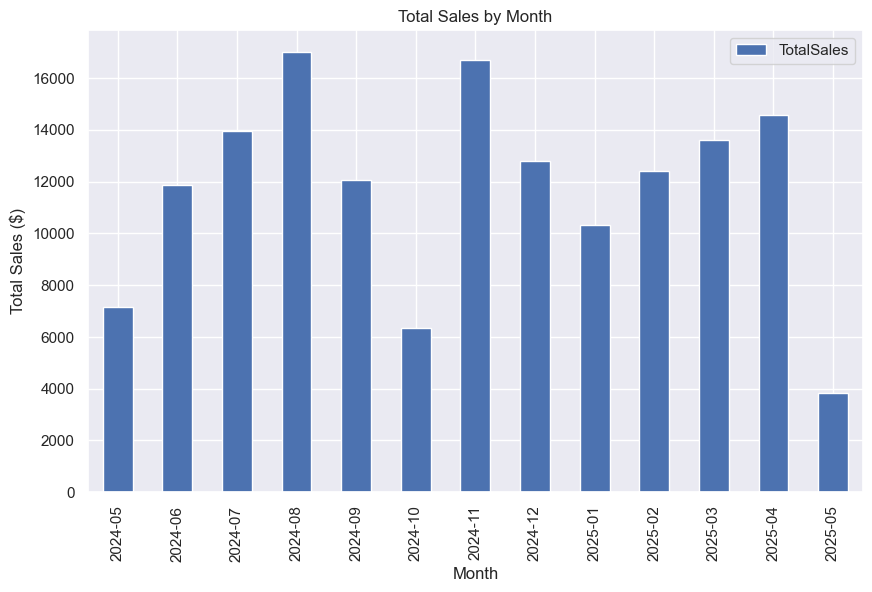

In [51]:
# Query: Total sales by month
query = """
SELECT strftime('%Y-%m', s.SaleDate) AS Month, SUM(s.TotalAmount) AS TotalSales
FROM Sales s
GROUP BY Month
ORDER BY Month
"""

# Use context manager to query the database
with sqlite3.connect("../data/sales_data.db") as conn:
    df_monthly = pd.read_sql_query(query, conn)

# Display the results
print(df_monthly)

# Visualize the results
df_monthly.plot(kind="bar", x="Month", y="TotalSales", title="Total Sales by Month")
plt.ylabel("Total Sales ($)")
plt.show()

Quarterly Sales - again I think these are standard baselines we can use to see if there are any outliers.

  Quarter  TotalSales
0      Q1    36357.36
1      Q2    37421.96
2      Q3    43044.77
3      Q4    35835.13


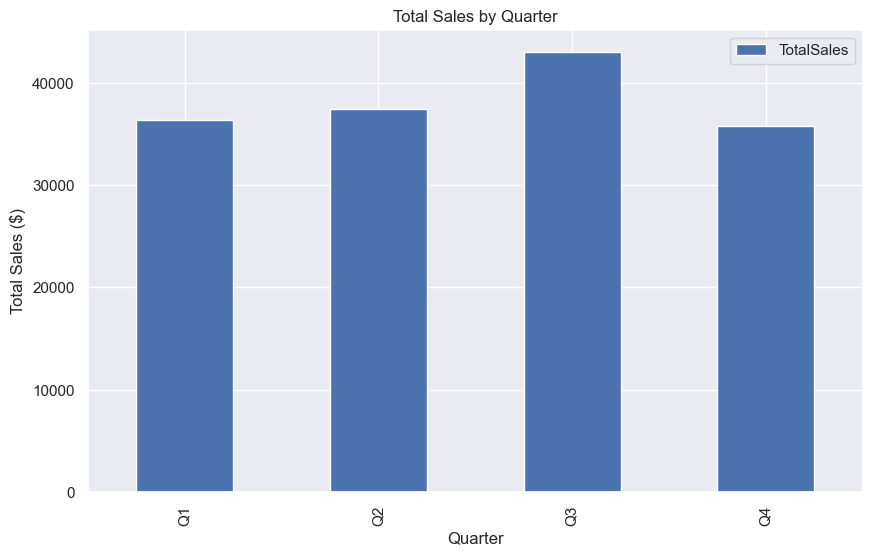

In [52]:
# Query: Total sales by quarter
query = """
SELECT 
    CASE 
        WHEN CAST(strftime('%m', s.SaleDate) AS INTEGER) BETWEEN 1 AND 3 THEN 'Q1'
        WHEN CAST(strftime('%m', s.SaleDate) AS INTEGER) BETWEEN 4 AND 6 THEN 'Q2'
        WHEN CAST(strftime('%m', s.SaleDate) AS INTEGER) BETWEEN 7 AND 9 THEN 'Q3'
        WHEN CAST(strftime('%m', s.SaleDate) AS INTEGER) BETWEEN 10 AND 12 THEN 'Q4'
    END AS Quarter,
    SUM(s.TotalAmount) AS TotalSales
FROM Sales s
GROUP BY Quarter
ORDER BY Quarter
"""

# Use context manager to query the database
with sqlite3.connect("../data/sales_data.db") as conn:
    df_quarterly = pd.read_sql_query(query, conn)

# Display the results
print(df_quarterly)

# Visualize the results
df_quarterly.plot(kind="bar", x="Quarter", y="TotalSales", title="Total Sales by Quarter")
plt.ylabel("Total Sales ($)")
plt.show()

Sales by day of the week, Monday - Sunday, which day are people indulging? 

   DayOfWeek  TotalSales
0     Monday    30169.00
1    Tuesday    20083.58
2  Wednesday    23383.16
3   Thursday    17178.51
4     Friday    17838.63
5   Saturday    19045.77
6     Sunday    24960.57


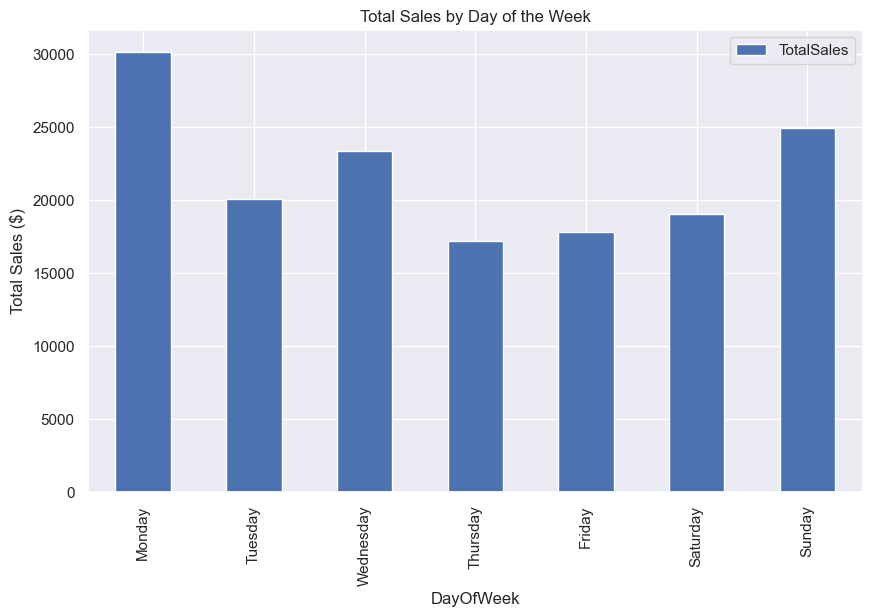

In [53]:
# Query: Total sales by day of the week (ordered Monday to Sunday)
query = """
SELECT 
    CASE strftime('%w', s.SaleDate)
        WHEN '0' THEN 'Sunday'
        WHEN '1' THEN 'Monday'
        WHEN '2' THEN 'Tuesday'
        WHEN '3' THEN 'Wednesday'
        WHEN '4' THEN 'Thursday'
        WHEN '5' THEN 'Friday'
        WHEN '6' THEN 'Saturday'
    END AS DayOfWeek,
    SUM(s.TotalAmount) AS TotalSales
FROM Sales s
GROUP BY DayOfWeek
ORDER BY 
    CASE strftime('%w', s.SaleDate)
        WHEN '1' THEN 1
        WHEN '2' THEN 2
        WHEN '3' THEN 3
        WHEN '4' THEN 4
        WHEN '5' THEN 5
        WHEN '6' THEN 6
        WHEN '0' THEN 7
    END
"""

# Use context manager to query the database
with sqlite3.connect("../data/sales_data.db") as conn:
    df_weekly = pd.read_sql_query(query, conn)

# Display the results
print(df_weekly)

# Visualize the results
df_weekly.plot(kind="bar", x="DayOfWeek", y="TotalSales", title="Total Sales by Day of the Week")
plt.ylabel("Total Sales ($)")
plt.show()

Rolling data to identify trends

      SaleDate  DailySales  Rolling7DaySales
0   2024-05-08      698.02               NaN
1   2024-05-12      100.48               NaN
2   2024-05-13     1261.34               NaN
3   2024-05-16      202.44               NaN
4   2024-05-17      976.40               NaN
..         ...         ...               ...
272 2025-05-03      453.67           2316.11
273 2025-05-04      457.63           2732.86
274 2025-05-05     1654.02           3888.16
275 2025-05-06      424.78           4032.27
276 2025-05-08      674.40           4397.97

[277 rows x 3 columns]


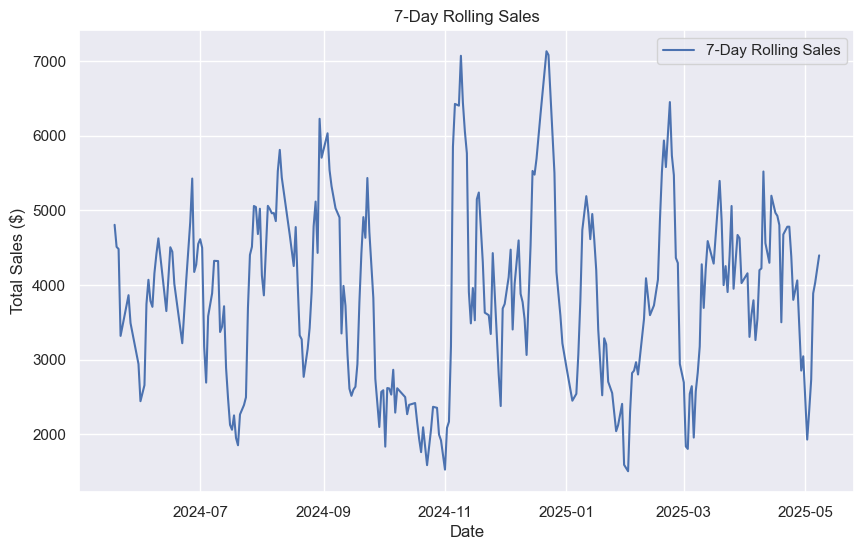

In [54]:
# Query: Daily sales
query = """
SELECT s.SaleDate, SUM(s.TotalAmount) AS DailySales
FROM Sales s
GROUP BY s.SaleDate
ORDER BY s.SaleDate
"""

# Use context manager to query the database
with sqlite3.connect("../data/sales_data.db") as conn:
    df_daily = pd.read_sql_query(query, conn)

# Convert SaleDate to datetime
df_daily['SaleDate'] = pd.to_datetime(df_daily['SaleDate'])

# Calculate rolling 7-day sales
df_daily['Rolling7DaySales'] = df_daily['DailySales'].rolling(window=7).sum()

# Display the results
print(df_daily)

# Visualize the results
plt.plot(df_daily['SaleDate'], df_daily['Rolling7DaySales'], label="7-Day Rolling Sales")
plt.title("7-Day Rolling Sales")
plt.xlabel("Date")
plt.ylabel("Total Sales ($)")
plt.legend()
plt.show()

Supplier sales starting with the most sales.

In [55]:
query = """
SELECT sp.SupplierName, SUM(s.TotalAmount) AS TotalSales
FROM Sales s
JOIN Products p ON s.ProductID = p.ProductID
JOIN Suppliers sp ON p.SupplierID = sp.SupplierID
GROUP BY sp.SupplierName
ORDER BY TotalSales DESC
"""
with sqlite3.connect("../data/sales_data.db") as conn:
    df_suppliers = pd.read_sql_query(query, conn)
print(df_suppliers)

                  SupplierName  TotalSales
0                 Gonzalez PLC    24194.36
1                  Avila Group    23654.35
2                  Garza-Brown    18049.38
3                     Mays Inc    15924.25
4       Moore, Lam and Edwards    14890.36
5                   Yang-Scott    14219.50
6                 Smith-Galvan    12454.09
7  Steele, Gonzalez and Foster    11582.48
8    Green, Braun and Peterson     9520.87
9               Adams-Melendez     8169.58


Monthly sales by category, I know it is mock data but we can see the trend of spirits going up in November.

      Month Category  TotalSales
0   2024-05     Beer     3566.14
1   2024-05  Spirits     2695.71
2   2024-05     Wine      884.95
3   2024-06     Beer     5625.65
4   2024-06  Spirits     3307.23
5   2024-06     Wine     2926.63
6   2024-07     Beer     4500.59
7   2024-07  Spirits     7419.28
8   2024-07     Wine     2050.94
9   2024-08     Beer     4634.94
10  2024-08  Spirits     8066.56
11  2024-08     Wine     4295.19
12  2024-09     Beer     4837.09
13  2024-09  Spirits     5699.03
14  2024-09     Wine     1541.15
15  2024-10     Beer     1974.60
16  2024-10  Spirits     2702.85
17  2024-10     Wine     1658.14
18  2024-11     Beer     5126.64
19  2024-11  Spirits     9009.54
20  2024-11     Wine     2566.45
21  2024-12     Beer     4586.87
22  2024-12  Spirits     4323.52
23  2024-12     Wine     3886.52
24  2025-01     Beer     4006.82
25  2025-01  Spirits     3818.08
26  2025-01     Wine     2503.54
27  2025-02     Beer     3852.71
28  2025-02  Spirits     4353.11
29  2025-0

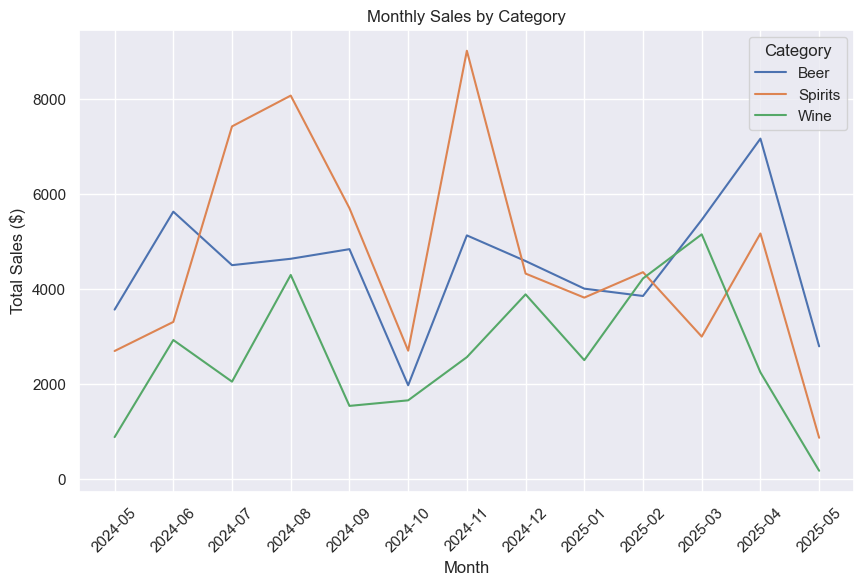

In [56]:
# Query: Monthly sales by category
query = """
SELECT strftime('%Y-%m', s.SaleDate) AS Month, p.Category, SUM(s.TotalAmount) AS TotalSales
FROM Sales s
JOIN Products p ON s.ProductID = p.ProductID
GROUP BY Month, p.Category
ORDER BY Month, p.Category
"""

# Use context manager to query the database
with sqlite3.connect("../data/sales_data.db") as conn:
    df_monthly_category = pd.read_sql_query(query, conn)

# Display the results
print(df_monthly_category)

# Optional: Visualize the results
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=df_monthly_category, x="Month", y="TotalSales", hue="Category")
plt.title("Monthly Sales by Category")
plt.ylabel("Total Sales ($)")
plt.xticks(rotation=45)
plt.show()

Regional total sales. Alabama is the top dog, or elephant in this case.

In [57]:

query = """
SELECT sp.Region, SUM(s.TotalAmount) AS TotalSales
FROM Sales s
JOIN Products p ON s.ProductID = p.ProductID
JOIN Suppliers sp ON p.SupplierID = sp.SupplierID
GROUP BY sp.Region
ORDER BY TotalSales DESC

"""

# Use context manager to query the database
with sqlite3.connect("../data/sales_data.db") as conn:
    df_sales_by_region = pd.read_sql_query(query, conn)
    
print(df_sales_by_region)

        Region  TotalSales
0      Alabama    24194.36
1     Delaware    23654.35
2         Iowa    18049.38
3   California    15924.25
4        Maine    14890.36
5     Oklahoma    14219.50
6   Washington    12454.09
7  Connecticut    11582.48
8     Illinois     9520.87
9    Louisiana     8169.58


Product sale count and the % of total for that product.

          ProductName  SalesCount  PercentOfTotal
0        Size Spirits          18             3.6
1         Friend Beer          17             3.4
2          Money Wine          16             3.2
3         His Spirits          16             3.2
4        Receive Beer          14             2.8
5           Push Wine          14             2.8
6           Half Wine          14             2.8
7         Arrive Beer          14             2.8
8        Another Beer          14             2.8
9         Method Wine          13             2.6
10             A Beer          13             2.6
11       Mention Beer          11             2.2
12       Many Spirits          11             2.2
13          Foot Beer          11             2.2
14     Follow Spirits          11             2.2
15          Fall Wine          11             2.2
16      Where Spirits          10             2.0
17      Third Spirits          10             2.0
18      Their Spirits          10             2.0


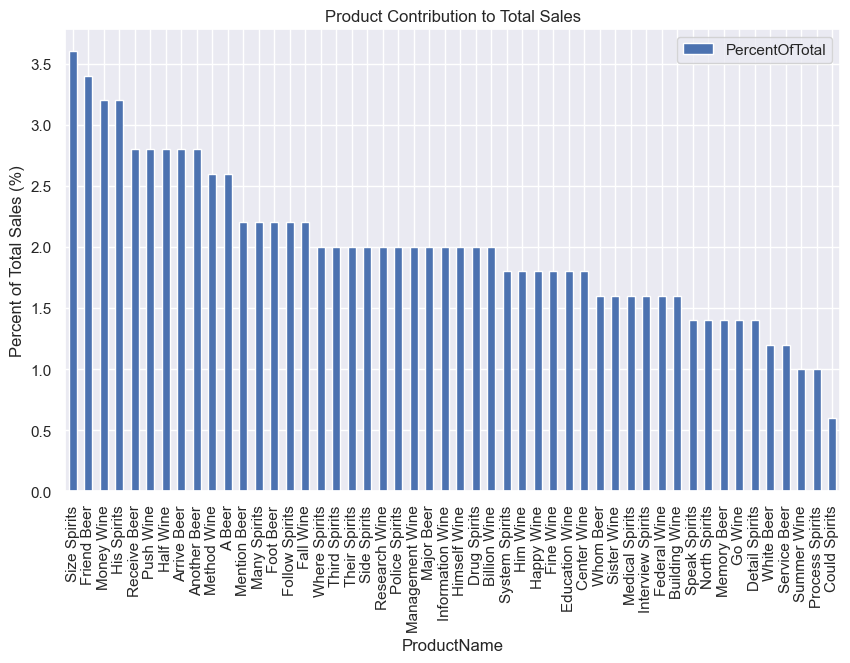

In [58]:
# Query: Product sales count
query = """
SELECT p.ProductName, COUNT(DISTINCT s.SaleID) AS SalesCount
FROM Sales s
JOIN Products p ON s.ProductID = p.ProductID
GROUP BY p.ProductName
ORDER BY SalesCount DESC
"""

# Use context manager to query the database
with sqlite3.connect("../data/sales_data.db") as conn:
    df_product_sales = pd.read_sql_query(query, conn)

# Calculate percent of total sales
df_product_sales['PercentOfTotal'] = (df_product_sales['SalesCount'] / df_product_sales['SalesCount'].sum()) * 100

# Print the DataFrame with PercentOfTotal
print(df_product_sales)

# Optional: Visualize the results
df_product_sales.plot(kind="bar", x="ProductName", y="PercentOfTotal", title="Product Contribution to Total Sales")
plt.ylabel("Percent of Total Sales (%)")
plt.xticks(rotation=90)
plt.show()

Yearly comparison for spirits, again the mock data lets us down a bit but seeing the year to year is important.

   Year Category  TotalSales  YearlyGrowth
0  2024  Spirits    43223.72           NaN
1  2025  Spirits    17206.99    -60.190863


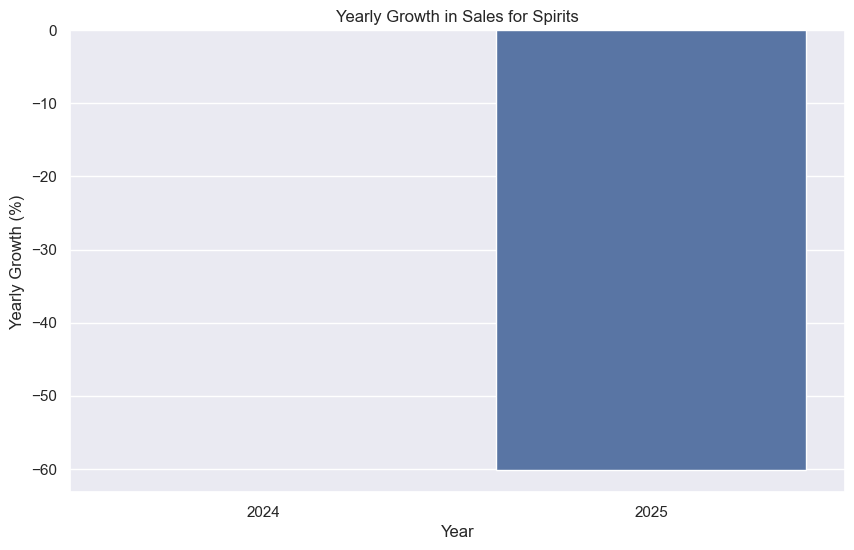

In [59]:
# Query: Yearly sales for Spirits
query = """
SELECT strftime('%Y', s.SaleDate) AS Year, p.Category, SUM(s.TotalAmount) AS TotalSales
FROM Sales s
JOIN Products p ON s.ProductID = p.ProductID
WHERE p.Category = 'Spirits'
GROUP BY Year, p.Category
ORDER BY Year
"""

# Use context manager to query the database
with sqlite3.connect("../data/sales_data.db") as conn:
    df_yearly_spirits = pd.read_sql_query(query, conn)

# Calculate yearly growth
df_yearly_spirits['YearlyGrowth'] = df_yearly_spirits['TotalSales'].pct_change() * 100

# Print the DataFrame with YearlyGrowth
print(df_yearly_spirits)

# Visualize the results
sns.barplot(data=df_yearly_spirits, x="Year", y="YearlyGrowth")
plt.title("Yearly Growth in Sales for Spirits")
plt.ylabel("Yearly Growth (%)")
plt.xlabel("Year")
plt.show()

    DayOfWeek DrinkType  TotalSales
0      Monday      Beer    10968.56
1      Monday   Spirits    13413.70
2      Monday      Wine     5786.74
3     Tuesday      Beer     8363.02
4     Tuesday   Spirits     6509.03
5     Tuesday      Wine     5211.53
6   Wednesday      Beer     9447.05
7   Wednesday   Spirits     9662.63
8   Wednesday      Wine     4273.48
9    Thursday      Beer     7707.59
10   Thursday   Spirits     5928.87
11   Thursday      Wine     3542.05
12     Friday      Beer     5227.51
13     Friday   Spirits     8115.84
14     Friday      Wine     4495.28
15   Saturday      Beer     7917.49
16   Saturday   Spirits     6612.89
17   Saturday      Wine     4515.39
18     Sunday      Beer     8489.83
19     Sunday   Spirits    10187.75
20     Sunday      Wine     6282.99


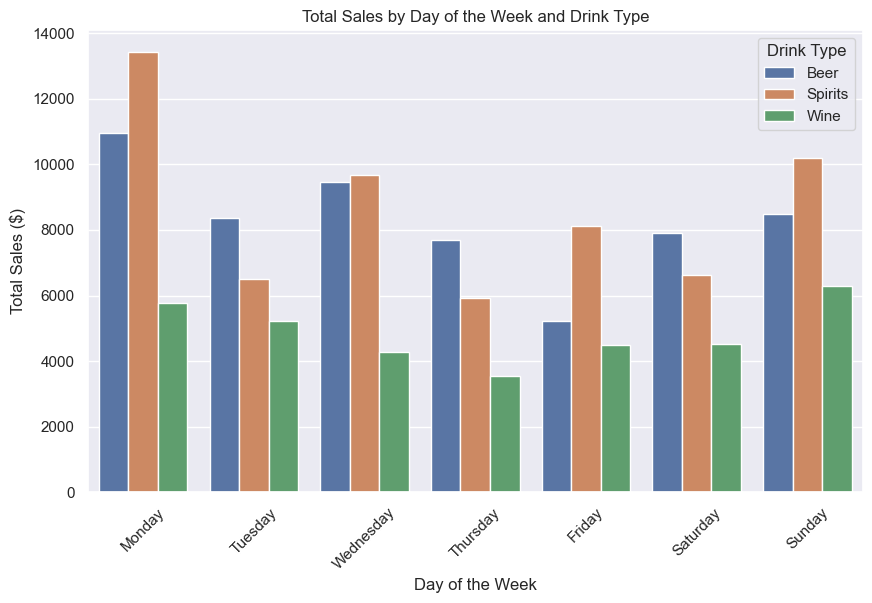

In [62]:
# Query: Total sales by day of the week and drink type
query = """
SELECT 
    CASE strftime('%w', s.SaleDate)
        WHEN '0' THEN 'Sunday'
        WHEN '1' THEN 'Monday'
        WHEN '2' THEN 'Tuesday'
        WHEN '3' THEN 'Wednesday'
        WHEN '4' THEN 'Thursday'
        WHEN '5' THEN 'Friday'
        WHEN '6' THEN 'Saturday'
    END AS DayOfWeek,
    p.Category AS DrinkType,
    SUM(s.TotalAmount) AS TotalSales
FROM Sales s
JOIN Products p ON s.ProductID = p.ProductID
GROUP BY DayOfWeek, DrinkType
ORDER BY 
    CASE strftime('%w', s.SaleDate)
        WHEN '1' THEN 1
        WHEN '2' THEN 2
        WHEN '3' THEN 3
        WHEN '4' THEN 4
        WHEN '5' THEN 5
        WHEN '6' THEN 6
        WHEN '0' THEN 7
    END,
    DrinkType
"""

# Use context manager to query the database
with sqlite3.connect("../data/sales_data.db") as conn:
    df_day_drink = pd.read_sql_query(query, conn)

# Display the results
print(df_day_drink)

# Visualize the results
sns.barplot(data=df_day_drink, x="DayOfWeek", y="TotalSales", hue="DrinkType")
plt.title("Total Sales by Day of the Week and Drink Type")
plt.ylabel("Total Sales ($)")
plt.xlabel("Day of the Week")
plt.xticks(rotation=45)
plt.legend(title="Drink Type")
plt.show()

        Region  TotalSales
0      Alabama    24194.36
1     Delaware    23654.35
2         Iowa    18049.38
3   California    15924.25
4        Maine    14890.36
5     Oklahoma    14219.50
6   Washington    12454.09
7  Connecticut    11582.48
8     Illinois     9520.87
9    Louisiana     8169.58


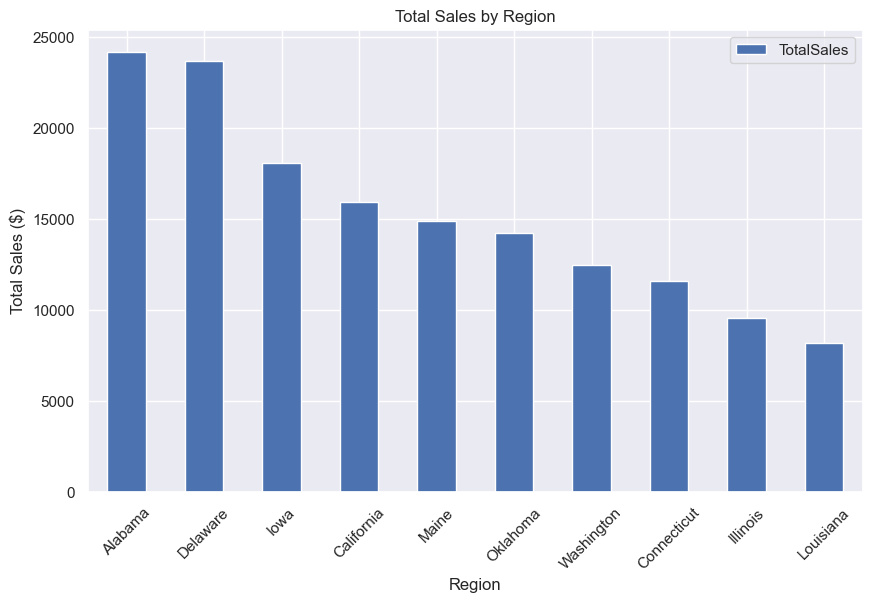

In [63]:
# Query: Regional total sales
query = """
SELECT sp.Region, SUM(s.TotalAmount) AS TotalSales
FROM Sales s
JOIN Products p ON s.ProductID = p.ProductID
JOIN Suppliers sp ON p.SupplierID = sp.SupplierID
GROUP BY sp.Region
ORDER BY TotalSales DESC
"""

# Use context manager to query the database
with sqlite3.connect("../data/sales_data.db") as conn:
    df_sales_by_region = pd.read_sql_query(query, conn)

# Display the results
print(df_sales_by_region)

# Visualize the results
df_sales_by_region.plot(kind="bar", x="Region", y="TotalSales", title="Total Sales by Region")
plt.ylabel("Total Sales ($)")
plt.xticks(rotation=45)
plt.show()

         Region DrinkType  TotalSales
0       Alabama      Beer     3821.60
1       Alabama   Spirits    15843.38
2       Alabama      Wine     4529.38
3    California      Beer    13195.87
4    California   Spirits     2728.38
5   Connecticut      Beer     1036.68
6   Connecticut   Spirits     6041.00
7   Connecticut      Wine     4504.80
8      Delaware      Beer     7741.87
9      Delaware   Spirits    10027.30
10     Delaware      Wine     5885.18
11     Illinois      Beer     6015.34
12     Illinois   Spirits     3505.53
13         Iowa      Beer     2867.04
14         Iowa   Spirits     4893.14
15         Iowa      Wine    10289.20
16    Louisiana      Beer     8169.58
17        Maine      Beer     4053.42
18        Maine   Spirits    10836.94
19     Oklahoma      Beer     3933.93
20     Oklahoma   Spirits     3865.87
21     Oklahoma      Wine     6419.70
22   Washington      Beer     7285.72
23   Washington   Spirits     2689.17
24   Washington      Wine     2479.20


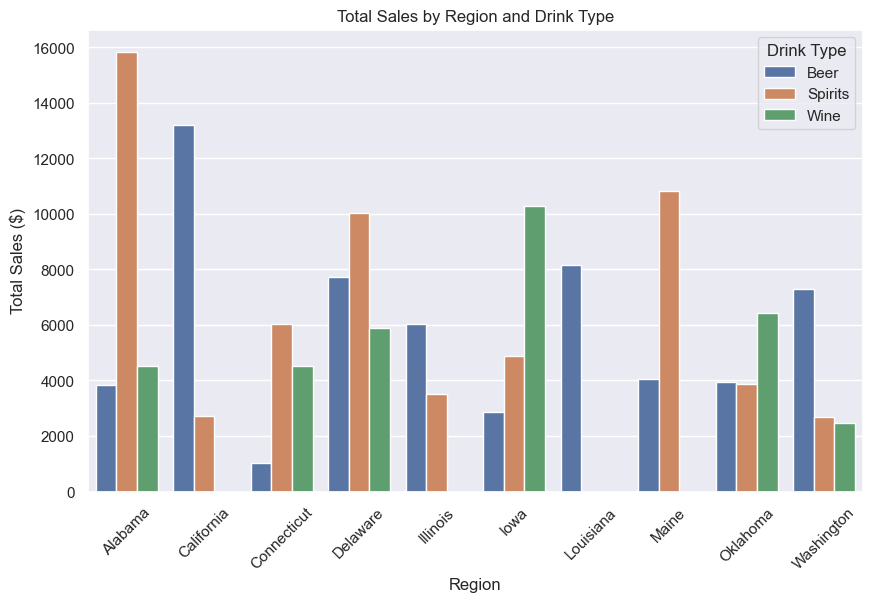

In [64]:
# Query: Total sales by region and drink type
query = """
SELECT 
    sp.Region AS Region,
    p.Category AS DrinkType,
    SUM(s.TotalAmount) AS TotalSales
FROM Sales s
JOIN Products p ON s.ProductID = p.ProductID
JOIN Suppliers sp ON p.SupplierID = sp.SupplierID
GROUP BY Region, DrinkType
ORDER BY Region, DrinkType;
"""

# Use context manager to query the database
with sqlite3.connect("../data/sales_data.db") as conn:
    df_region_drink = pd.read_sql_query(query, conn)

# Display the results
print(df_region_drink)

# Visualize the results
sns.barplot(data=df_region_drink, x="Region", y="TotalSales", hue="DrinkType")
plt.title("Total Sales by Region and Drink Type")
plt.ylabel("Total Sales ($)")
plt.xlabel("Region")
plt.xticks(rotation=45)
plt.legend(title="Drink Type")
plt.show()

In [65]:
# Query: Inspect sales data for Louisiana
query = """
SELECT sp.Region, p.Category AS DrinkType, s.TotalAmount
FROM Sales s
JOIN Products p ON s.ProductID = p.ProductID
JOIN Suppliers sp ON p.SupplierID = sp.SupplierID
WHERE sp.Region = 'Louisiana'
"""

# Use context manager to query the database
with sqlite3.connect("../data/sales_data.db") as conn:
    df_louisiana = pd.read_sql_query(query, conn)

# Display the results
print(df_louisiana)

       Region DrinkType  TotalAmount
0   Louisiana      Beer       631.80
1   Louisiana      Beer        22.20
2   Louisiana      Beer        67.12
3   Louisiana      Beer         8.39
4   Louisiana      Beer       144.30
5   Louisiana      Beer        16.78
6   Louisiana      Beer       631.80
7   Louisiana      Beer       252.72
8   Louisiana      Beer        55.50
9   Louisiana      Beer        83.24
10  Louisiana      Beer        11.10
11  Louisiana      Beer        36.52
12  Louisiana      Beer       117.46
13  Louisiana      Beer       693.88
14  Louisiana      Beer       336.96
15  Louisiana      Beer       155.40
16  Louisiana      Beer       219.12
17  Louisiana      Beer        92.29
18  Louisiana      Beer       159.41
19  Louisiana      Beer       547.56
20  Louisiana      Beer       416.20
21  Louisiana      Beer       134.24
22  Louisiana      Beer       228.91
23  Louisiana      Beer       133.20
24  Louisiana      Beer        44.40
25  Louisiana      Beer       117.46
2